In [51]:
# importing all libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scikeras
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from pprint import pprint
import datetime as dt
from datetime import datetime
import json

In [52]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [53]:
# importing prepared csv file
df_cleaned = pd.read_csv('prepared_df.csv')

In [54]:
# showing the header of the cleaned csv header
df_cleaned.head()

,Unnamed: 0,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,soortWoning_cleaned,postcode_prepared
0,0,139000.0,1971,1,3,62,8985600000000000,vrijstaande_woning,0
1,2,267500.0,2001,0,3,70,9763200000000000,appartement,1
2,3,349000.0,1973,1,5,144,11404800000000000,eengezinswoning,2
3,4,495000.0,1900,0,8,323,10627200000000000,vrijstaande_woning,3
4,5,162500.0,1970,1,4,68,20995200000000000,eengezinswoning,4


In [55]:
# showing all data types and making sure that all of them are integers or float except the soortwoning which still has to be dummified
df_cleaned.dtypes

Unnamed: 0               int64
koopPrijs              float64
bouwjaar                 int64
indTuin                  int64
aantalKamers             int64
oppervlakte              int64
Time_to_sell             int64
soortWoning_cleaned     object
postcode_prepared        int64
dtype: object

In [56]:
# checking for null values
df_cleaned.isnull().sum()

Unnamed: 0             0
koopPrijs              0
bouwjaar               0
indTuin                0
aantalKamers           0
oppervlakte            0
Time_to_sell           0
soortWoning_cleaned    0
postcode_prepared      0
dtype: int64

In [57]:
# the last transformation to make the data set ready for modelling
df= df_cleaned
columns = ['Time_to_sell']
for col in columns:
    df[col] = df[col].astype('int64')

df = df_cleaned.rename(columns={'Unnamed: 0': 'id'})

In [58]:
# defining the splitter to split the data set between training, testing and validation sets
class TrainTestSplitter(object):
    '''Class to perform the split of the data into train, test, and validation.
    '''
    def __init__(self, train_frac=0.8, validation_frac=0.2, seed=1234):
        self.train_frac = train_frac
        self.validation_frac = validation_frac
        self.seed = seed

    def split_train_test(self, df):
        print("Generating the train/validation/test splits...")
        self.train_set = df.sample(frac=self.train_frac, random_state=self.seed)
        self.test_set = df.loc[lambda x: ~x.id.isin(self.train_set.id)].reset_index(drop=True)
        self.validation_set = self.train_set.sample(frac=self.validation_frac).reset_index(drop=True)
        self.train_set = self.train_set.loc[lambda x: ~x.id.isin(self.validation_set.id)].reset_index(drop=True)
        print("calculating the statistics...")
        print("split completed")

In [59]:
# create a fitting_splits object that will hold the train, validation, and test data
fitting_splits = TrainTestSplitter()
fitting_splits.split_train_test(df)

Generating the train/validation/test splits...
calculating the statistics...
split completed


In [60]:
# checking if they're devided correctly
fitting_splits.train_set.shape
fitting_splits.test_set.shape
fitting_splits.validation_set.shape

(131274, 9)

(41023, 9)

(32818, 9)

In [61]:
# dummify the soortWoning column, in the training set: from catagory to integer 
# this needs to be done, so the outcomes become numbers. Only number can be used in creating the model.
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(fitting_splits.train_set[['soortWoning_cleaned']])

OneHotEncoder()

In [62]:
# apply the encoder
one_hot_encoder.categories_ # after we fit the encoder, the instance learns which values are present in each data column.
encoded_names = one_hot_encoder.get_feature_names_out() # with this method we can retrieve the names of the new dummy columns that have been computed
encoded_names

encoded_categories = one_hot_encoder.transform(fitting_splits.train_set[['soortWoning_cleaned']]).toarray() # at this point, we can use the fitted encoder to transform any array with a sex and marriage column; not just the training set, but also the validation or test set. The encoder will take that array of shape (M,2) and transform it to an array of shape (M, N), where N is the total number of distinct possible values for the encoded features. The values of the new array will be either 0 or 1, encoding whether that value of the feature applies to the row.
df_encoded = pd.DataFrame(encoded_categories)
df_encoded.columns = encoded_names
df_encoded

[array(['appartement', 'benedenwoning', 'bovenwoning', 'eengezinswoning',
        'herenhuis', 'other', 'portiekflat', 'vrijstaande_woning'],
       dtype=object)]

array(['soortWoning_cleaned_appartement',
       'soortWoning_cleaned_benedenwoning',
       'soortWoning_cleaned_bovenwoning',
       'soortWoning_cleaned_eengezinswoning',
       'soortWoning_cleaned_herenhuis', 'soortWoning_cleaned_other',
       'soortWoning_cleaned_portiekflat',
       'soortWoning_cleaned_vrijstaande_woning'], dtype=object)

,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,soortWoning_cleaned_bovenwoning,soortWoning_cleaned_eengezinswoning,soortWoning_cleaned_herenhuis,soortWoning_cleaned_other,soortWoning_cleaned_portiekflat,soortWoning_cleaned_vrijstaande_woning
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
131269,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131270,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
131271,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131272,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# dropping the non dummified woning column and the adding the dummified array to our training dataset
train_set = fitting_splits.train_set.drop(['soortWoning_cleaned'], axis=1)
train_set = pd.concat([train_set, df_encoded], axis=1)
train_set

,id,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,postcode_prepared,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,soortWoning_cleaned_bovenwoning,soortWoning_cleaned_eengezinswoning,soortWoning_cleaned_herenhuis,soortWoning_cleaned_other,soortWoning_cleaned_portiekflat,soortWoning_cleaned_vrijstaande_woning
0,9239,249500.0,1939,1,6,105,1296000000000000,8894,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,30049,698000.0,1937,1,6,178,23328000000000000,29092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,163972,289500.0,1956,1,4,123,2419200000000000,160641,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,181829,189000.0,1966,0,3,62,2332800000000000,178244,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32736,298000.0,1996,1,5,116,13392000000000000,31722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131269,171619,250000.0,2005,1,3,73,1296000000000000,168188,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131270,150845,209000.0,1981,1,6,120,1382400000000000,147665,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
131271,6265,189000.0,1995,0,4,72,8467200000000000,6020,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131272,27376,195000.0,1982,0,1,29,1123200000000000,26489,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# applying the scaler
standard_scaler = StandardScaler()
standard_scaler.fit(train_set)

StandardScaler()

In [65]:
class DataPreparer(object):
    def __init__(self, one_hot_encoder, standard_scaler):
        self.one_hot_encoder = one_hot_encoder
        self.standard_scaler = standard_scaler

    def dummify(self, df):
        vars_to_encode = ['soortWoning_cleaned']
        df_to_encode = df[vars_to_encode]
        df_encoded = self.one_hot_encoder.transform(df_to_encode).toarray()
        df_encoded = pd.DataFrame(df_encoded)
        df_encoded.columns = self.one_hot_encoder.get_feature_names_out()
        # add the encoded columns and drop the original columns
        df = df.drop(vars_to_encode,axis=1)
        df = pd.concat([df, df_encoded], axis=1)
        return df

    def scale(self, df):
        cols = df.columns
        df = self.standard_scaler.transform(df)
        df = pd.DataFrame(df)
        df.columns = cols
        return df

    def prepare_data(self, df):
        df = df.reset_index(drop=True)
        # first dummify the data
        df = self.dummify(df)
        # then scale it
        df = self.scale(df)
        return df

In [66]:
# applying one hot encoder and standard scaler
data_preparer = DataPreparer(one_hot_encoder, standard_scaler)
data_preparer.prepare_data(fitting_splits.train_set).head()
data_preparer.prepare_data(fitting_splits.validation_set).head()

,id,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,postcode_prepared,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,soortWoning_cleaned_bovenwoning,soortWoning_cleaned_eengezinswoning,soortWoning_cleaned_herenhuis,soortWoning_cleaned_other,soortWoning_cleaned_portiekflat,soortWoning_cleaned_vrijstaande_woning
0,-1.590274,-0.356729,-0.905912,0.636142,0.859377,-0.303818,-0.673633,-1.586286,-0.501026,-0.080729,-0.127226,0.951929,-0.181376,-0.191888,-0.149823,-0.441314
1,-1.249147,1.946539,-0.957764,0.636142,0.859377,1.191625,2.917608,-1.249193,-0.501026,-0.080729,-0.127226,-1.050499,-0.181376,-0.191888,-0.149823,2.265962
2,0.946180,-0.151310,-0.465164,0.636142,-0.421143,0.064922,-0.490550,0.946286,-0.501026,-0.080729,-0.127226,0.951929,-0.181376,-0.191888,-0.149823,-0.441314
3,1.238901,-0.667427,-0.205901,-1.571977,-1.061403,-1.184695,-0.504634,1.240070,1.995905,-0.080729,-0.127226,-1.050499,-0.181376,-0.191888,-0.149823,-0.441314
4,-1.205100,-0.107658,0.571889,0.636142,0.219117,-0.078477,1.298029,-1.205299,-0.501026,-0.080729,-0.127226,-1.050499,-0.181376,-0.191888,-0.149823,2.265962


,id,koopPrijs,bouwjaar,indTuin,aantalKamers,oppervlakte,Time_to_sell,postcode_prepared,soortWoning_cleaned_appartement,soortWoning_cleaned_benedenwoning,soortWoning_cleaned_bovenwoning,soortWoning_cleaned_eengezinswoning,soortWoning_cleaned_herenhuis,soortWoning_cleaned_other,soortWoning_cleaned_portiekflat,soortWoning_cleaned_vrijstaande_woning
0,-1.359632,-0.107658,1.168194,0.636142,0.859377,0.577059,1.002279,-1.358475,-0.501026,-0.080729,-0.127226,0.951929,-0.181376,-0.191888,-0.149823,-0.441314
1,1.051633,-0.921633,-0.361459,-1.571977,-1.701663,-1.594405,-0.701800,1.052214,-0.501026,-0.080729,-0.127226,-1.050499,-0.181376,-0.191888,6.674550,-0.441314
2,0.110313,1.129996,0.623741,0.636142,1.499637,1.683277,-0.082135,0.109561,-0.501026,-0.080729,-0.127226,-1.050499,-0.181376,-0.191888,-0.149823,2.265962
3,-1.497870,0.621582,-0.257754,-1.571977,-1.701663,-1.451006,1.368445,-1.496029,1.995905,-0.080729,-0.127226,-1.050499,-0.181376,-0.191888,-0.149823,-0.441314
4,-1.140694,0.031000,0.364478,0.636142,0.219117,-0.324303,-0.603217,-1.141646,-0.501026,-0.080729,-0.127226,0.951929,-0.181376,-0.191888,-0.149823,-0.441314


In [67]:
# create training variables to measure the buying price
train_set_transformed = data_preparer.prepare_data(fitting_splits.train_set)
X_train = train_set_transformed.drop(['koopPrijs', 'id'], axis=1) # need to drop the target! otherwise data leakage
y_train = fitting_splits.train_set['koopPrijs'] # take it from the original untransformed dataset

In [68]:
# now we can use the fitted random tree model to predict on the test dataset
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['koopPrijs', 'id'], axis=1)
y_test = fitting_splits.test_set['koopPrijs']

In [69]:
# testing model and printing the accuracy measured by the MSE
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RandomForestRegressor(random_state=0)

Mean Absolute Error: 76141.36224410696
Mean Squared Error: 17676097771.085148
Root Mean Squared Error: 132951.48653206232


In [70]:
# overview off all hyperparameters
rf = RandomForestRegressor(random_state = 42)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [71]:
# creating a grid from the hypertuning parameters

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 400, num = 4)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 80, num = 4)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
pprint(random_grid)

{'max_depth': [20, 40, 60, 80], 'n_estimators': [100, 200, 300, 400]}


In [72]:
# defining the model

def fit_svm_model(X_train, y_train, n_estimators, max_depth):
    # create the model instance with the required parameters
    simple_RFR = RandomForestRegressor(random_state=1234)
    # fit the model instance on X_train
    simple_RFR.fit(X=X_train, y=y_train)
    return simple_RFR

 # will hold the models fitted on train, for each hyperparameter combination
fitted_models = []

# train a model for each hyperparameter combo
print("begin hypertuning")
for N in n_estimators:
    for Depth in max_depth:
        # fit a model with the given hyperparameter values.
        # A new model will be fitted for each loop cycle
        print(f"fitting model for n_estimators: {N} and max_depth: {Depth}")
        fitted_model = fit_svm_model(X_train, y_train, N, Depth)
        print(f"fitting complete.")
        # store the fitted model in the fitted_model list
        fitted_models.append(fitted_model)


begin hypertuning
fitting model for n_estimators: 100 and max_depth: 20
fitting complete.
fitting model for n_estimators: 100 and max_depth: 40


KeyboardInterrupt: 

In [73]:
# showing the first four models
fitted_models[0:4]

[RandomForestRegressor(random_state=1234)]

In [74]:
# put train & validation sets together
X_validation = data_preparer.prepare_data(fitting_splits.validation_set).drop(['koopPrijs', 'id'], axis=1)
y_validation = fitting_splits.validation_set['koopPrijs']
X_train_validation = pd.concat([X_train, X_validation])
y_train_validation = pd.concat([y_train, fitting_splits.validation_set['koopPrijs']])

In [75]:
# calculating MSE for the model
def calculate_MSE(X, y, model):
    y_hat = model.predict(X)
    return metrics.mean_squared_error(y, y_hat)
MSE = [calculate_MSE(X_validation, y_validation, m) for m in fitted_models]

In [76]:
# showing the first 20 MSE scores
MSE[:20]

[20329362422.243908]

In [77]:
# find the best MSE from the hypertuning
max_MSE = max(MSE)
best_model_index = MSE.index(max_MSE)
best_model = fitted_models[best_model_index]

In [78]:
# printing best parameters
print(f"The best value of n estimators found is {best_model.n_estimators}")
print(f"The best value of max depth is {best_model.max_depth}")

The best value of n estimators found is 100
The best value of max depth is None


In [79]:
# selecting model with best parameters
selected_model = RandomForestRegressor(n_estimators = best_model.n_estimators, max_depth = best_model.max_depth, random_state=1234)
selected_model.fit(X_train_validation, y_train_validation)

RandomForestRegressor(random_state=1234)

In [80]:
# now predict on test with the fitted model to get the final performance measure
X_test = data_preparer.prepare_data(fitting_splits.test_set).drop(['koopPrijs', 'id'],axis=1)
y_test = fitting_splits.test_set['koopPrijs']
calculate_MSE(X_test, y_test, selected_model)

17597025633.36699

# Neural Network Modelling

In [81]:
# importing libraries 
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
import keras
print('keras: %s' % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense

tensorflow: 2.7.0
keras: 2.7.0


In [82]:
# printing best amount of neurons per layer
print(f"The number of neurons for the input layer must be: {X_train.shape[1]}")

The number of neurons for the input layer must be: 14


In [83]:
# define the neural network model class instance
simple_nn = Sequential()
# we set the number of neurons to be equal to the (# of nodes in the input layer + # neurons in the output layer)/2,
simple_nn.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
# add the output layer with sigmoid function (the sigmoid function is exactly the same as that used in the formulation of logisitc regression
simple_nn.add(Dense(1))

In [84]:
print(simple_nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                150       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________
None


In [85]:
# selecting MSE as loss function for the regression problem
simple_nn.compile(loss='mean_squared_error', optimizer='adam')

In [86]:
# checking shapes of arrays 
X_train.shape
y_train.shape
X_validation.shape
y_validation.shape

(131274, 14)

(131274,)

(32818, 14)

(32818,)

In [88]:
# running the model
simple_nn.fit(X_train, y_train, epochs=150, batch_size = 500)

Epoch 1/150
263/263 [==============================] - 1s 2ms/step - loss: 139653709824.0000
Epoch 2/150
263/263 [==============================] - 0s 1ms/step - loss: 139649187840.0000
Epoch 3/150
263/263 [==============================] - 1s 2ms/step - loss: 139638833152.0000
Epoch 4/150
263/263 [==============================] - 0s 2ms/step - loss: 139623383040.0000
Epoch 5/150
263/263 [==============================] - 0s 2ms/step - loss: 139602345984.0000
Epoch 6/150
263/263 [==============================] - 0s 2ms/step - loss: 139575853056.0000: 0s - loss: 1381880
Epoch 7/150
263/263 [==============================] - 0s 2ms/step - loss: 139544772608.0000
Epoch 8/150
263/263 [==============================] - 0s 1ms/step - loss: 139509694464.0000
Epoch 9/150
263/263 [==============================] - 0s 2ms/step - loss: 139470913536.0000
Epoch 10/150
263/263 [==============================] - 0s 2ms/step - loss: 139428577280.0000
Epoch 11/150
263/263 [===========================

dict_keys(['loss'])

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

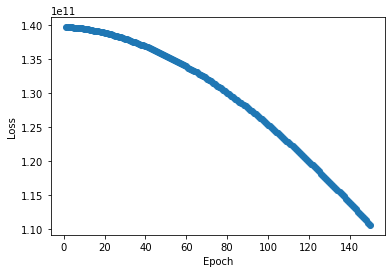

In [89]:
# see what information has been logged during the training process
simple_nn.history.history.keys()

# plot the training loss over epochs
loss_df = pd.DataFrame(simple_nn.history.history['loss'])
loss_df.columns = ['loss']
loss_df = loss_df.assign(epoch = np.arange(1, 151))

y = loss_df['loss']
x = loss_df['epoch']

plt.scatter(x,y)
#plt.plot(x,y)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [90]:
# running the model
simple_nn.fit(X_train, y_train, epochs=5, batch_size = 20, validation_data=(X_validation, y_validation))

Epoch 1/5
6564/6564 [==============================] - 14s 2ms/step - loss: 106782302208.0000 - val_loss: 109168287744.0000
Epoch 2/5
6564/6564 [==============================] - 12s 2ms/step - loss: 99527155712.0000 - val_loss: 101531213824.0000
Epoch 3/5
6564/6564 [==============================] - 14s 2ms/step - loss: 92028665856.0000 - val_loss: 93765468160.0000
Epoch 4/5
6564/6564 [==============================] - 15s 2ms/step - loss: 84321951744.0000 - val_loss: 85876097024.0000
Epoch 5/5
6564/6564 [==============================] - 14s 2ms/step - loss: 76702515200.0000 - val_loss: 78154055680.0000


Text(0.5, 1.0, 'model loss')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

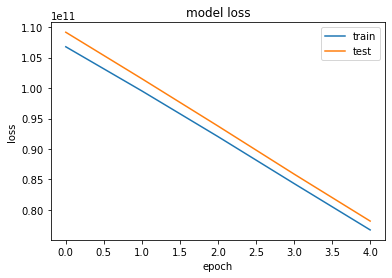

In [91]:
# see what information has been logged during the training process
plt.plot(simple_nn.history.history['loss'])
plt.plot(simple_nn.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [92]:
# save the above simple nn fitted model to look at it later. We need to use the keras save command
# this command will save all the components of the model, in particular the architecture and the weights
# note: it will NOT save the training history. This needs to be saved separately.
simple_nn.save('../dataset/simple_nn_model')

print("Storing the fitting history of simple nn to disk")
with open('../dataset/simple_nn_history.json', 'w') as handle:
    json.dump(simple_nn.history.history, handle)

INFO:tensorflow:Assets written to: ../dataset/simple_nn_model\assets
Storing the fitting history of simple nn to disk


In [93]:
# we can load the above save model like this:
simple_nn = keras.models.load_model("../dataset/simple_nn_model")
#simple_nn

#reload the fitting history like this
with open("../dataset/simplen_nn_history.json", "r") as handle:
    simple_nn_history = json.load(handle)

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/simplen_nn_history.json'

In [ ]:
# calculating the MSE
final_nn = Sequential()
final_nn.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
final_nn.add(Dense(1))
final_nn.compile(loss=tensorflow.keras.losses.MeanSquaredError(), optimizer='sgd')
final_nn.fit(X_train_validation, y_train_validation, epochs=3, batch_size = 20, verbose=0)
y_hat_test_nn = final_nn.predict(X_test)
y_hat_test_nn = np.where(y_hat_test_nn >= 0.5, 1, 0)
print("The MSE of the nn model is {}".format(metrics.mean_squared_error(y_test, y_hat_test_nn)))

The MSE of the nn model is 144193519207.57736


In [ ]:
# function that creates the model
# note that we pass the number of neurons as a parameter to the network
def create_model(neurons=1):
    nn_model = Sequential()
    nn_model.add(Dense(neurons, input_dim=X_train.shape[1], activation="relu"))
    nn_model.add(Dense(1))
    nn_model.compile(loss='', optimizer='adam')
    return nn_model

seed = 1234
np.random.seed(seed)

# turn the keras model into a sklearn compatible model
# note that the neurons parameter needs to be specified in the interface of KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0, neurons=1)

In [ ]:
# define the grid search parameters
batch_size = [10, 20]
epochs = [100, 150]
neurons = [10, 20, 30]
params_grid = dict(batch_size=batch_size, epochs=epochs, neurons=neurons)

In [ ]:
# showing parameter options
params_grid

{'batch_size': [10, 20], 'epochs': [100, 150], 'neurons': [10, 20, 30]}

In [ ]:
# use PredefinedSplit to specify which observations are train and which are validation
fold_index = PredefinedSplit([-1]* X_train.shape[0] + [0] * X_validation.shape[0])

# define the parameter grid as a dictionary of lists, where the keys are the names of the parameters
#param_grid = {'n_estimators': n_estimators.tolist(), 'max_depth': max_depth.tolist()}
param_grid = [n_estimators,max_depth]

In [ ]:
#perform grid search with sklearn if needed, otherwise load the grid search already performed
if os.path.exists("../dataset/nn_grid_search.pickle") and USE_STORED_NN_HYPERTUNED_MODELS is True:
    with open('../dataset/nn_grid_search.pickle', 'rb') as handle:
        grid_search_nn = pickle.load(handle)
else:
    start_time = datetime.datetime.now()
    grid_search_nn = GridSearchCV(estimator=model, param_grid=params_grid, n_jobs=-1, cv=fold_index)
    grid_search_nn = grid_search_nn.fit(X_train_validation, y_train_validation)
    end_time = datetime.datetime.now()
    print(f'hypertuning with sklearn grid search for neural networks complete in {round((end_time - start_time).seconds/60, 2)} minutes')
        store the results of the grid search to disk
with open('../dataset/nn_grid_search.pickle', 'wb') as handle:
    pickle.dump(grid_search_nn, handle)

In [ ]:
grid_search_nn

In [ ]:
print("The best parameter combination is: {} with score: {}".format(grid_search_nn.best_params_, grid_search_nn.best_score_))

In [ ]:
best_model = create_model(20)
best_model.fit(X_train_validation, y_train_validation, epochs=100, batch_size=10, verbose=0)

In [ ]:
y_hat_test = best_model.predict(X_test)
y_hat_test = np.where(y_hat_test >= 0.5, 1, 0)
f1_score(y_test, y_hat_test)